In this part we wanted to explore whether a good beer is a good beer everywhere? In other words is a beer that is well rated preceived as good everywhere or rather does where you live and culture affect how you rate a beer. Do your country, entourage, habits make you like a beer more or less?

Culture can play a role in how an individual perceives and rates a beer, as cultural influences can shape an individual's taste preferences and expectations for different types of beer. For example, a person from a culture with a strong tradition of brewing and consuming hoppy beers may have different preferences and expectations for a hoppy beer compared to someone from a culture with a different tradition.

It's important to note that these cultural influences are just one factor among many that can affect an individual's rating of a beer but we thought this was one of the most interesting factors affecting how you could rate a beer given the data we have.

In [227]:
#reading data
import gzip 

#manipulating data 
import pandas as pd
import numpy as np
import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from math import pi

import plotly.express as px
import plotly.graph_objects as go

import random


#clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

#creating a map 
import folium 

#pca
from pca import pca

#numpy normalize
from numpy.linalg import norm

In [3]:
PATH= '../'

We start by loading both dataframes from BeerAdvocate and RateBeer:

In [12]:
df_BA_reviews = pd.read_csv('../DataframeStorage/df_BA_reviews.csv')
df_BA_reviews['date'] = pd.to_datetime(df_BA_reviews['date'], format="%Y-%m-%d %H:%M:%S")

In [11]:
df_RB_reviews = pd.read_csv('../DataframeStorage/df_RB_reviews.csv')
df_RB_reviews['date'] = pd.to_datetime(df_RB_reviews['date'], format="%Y-%m-%d %H:%M:%S")

Since here we work on locations, we define two new dataframes where we remove all the unknown locations:

In [13]:
df_BA_reviews_location = df_BA_reviews[(df_BA_reviews.user_location!='Unknown') & (df_BA_reviews.brewery_location!='Unknown')]
df_RB_reviews_location = df_RB_reviews[(df_RB_reviews.user_location!='Unknown') & (df_RB_reviews.brewery_location!='Unknown')]

We'll concatenate both dataframes from BeerAdvocate and RateBeer to put all the data together since they contain the same features:

In [14]:
df_reviews_locations = pd.concat([df_BA_reviews_location, df_RB_reviews_location], axis=0)

In [8]:
df_reviews_locations.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,brewery_location,brewery_merged_location,user_location,user_merged_location
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",Gabon,Gabon,"United States, Washington",United States
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,Northern Ireland,Northern Ireland,"United States, New York",United States


## Map visualization 

we start by plotting a map where we can visualize the different countries with the number of reviews per country:

We first define a df_country dataframe with the longitudes and latitudes of the world countries and US states in order to be able to plot maps. The data for the coordinates is taken from [here](https://www.mapsofworld.com/world-maps/world-map-with-latitude-and-longitude.html) and [here](https://www.mapsofworld.com/lat_long/usa-lat-long.html). There were some areas missing from the data we got so we added the missing locations manually using google maps coordinates.

In [89]:
df_country_coordinates = pd.read_csv('../country2.csv')
df_country_coordinates = df_country_coordinates[['name','Latitude', 'Longitude']]

df_US_states_coordinates= pd.read_csv('../US_states.csv', index_col= 'name')
df_US_states_coordinates = df_US_states_coordinates.reset_index(level=0)
df_US_states_coordinates['name'] = df_US_states_coordinates['name'].apply(lambda x: 'United States, ' + x)

frames = [df_country_coordinates, df_US_states_coordinates]
df_coordinates = pd.concat(frames)
df_coordinates = df_coordinates.set_index('name')

Next we define a dataframe that contains the count of users from each country to plot the map:

In [120]:
df_map = pd.DataFrame(df_reviews_locations['user_location'].value_counts())
df_map.index.name='name'

There are few locations where the name in df_reviews_locations differs from the one in the country coordinates we have. Also there are a two countries reffered to in two different ways. So we change them accordingly:

In [121]:
df_map = df_map.rename(index={'Virgin Islands (British)': 'British Virgin Islands', 'Virgin Islands (U.S.)':'U.S. Virgin Islands'})
df_map.loc['New Zealand']=df_map.loc['Aotearoa']['user_location']+df_map.loc['New Zealand']['user_location']
df_map.loc['Slovakia']=df_map.loc['Slovakia']['user_location']+df_map.loc['Slovak Republic']['user_location']

We join the coordinate data with the user location count data:

In [122]:
df_map = df_map.join(df_coordinates)
df_map = df_map.dropna(axis=0)

In [124]:
df_map.head()

,user_location,Latitude,Longitude
name,,,
Canada,663769,56.130366,-106.346771
Denmark,582636,56.26392,9.501785
"United States, California",536188,36.778261,-119.417932
"United States, Pennsylvania",472818,41.203322,-77.194525
England,462653,52.3555177,-1.174320


Next we plot the data on a map using plotly:

In [258]:
# Create the figure and plot
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=df_map['Longitude'],
    lat=df_map['Latitude'],
    text=df_map.index,
    marker=go.scattergeo.Marker(
        size=df_map['user_location'],
        sizemode='area',
        sizeref=2*max(df_map['user_location'])/(100**2),
        sizemin=1,
    ),

    hovertext=df_map.index,
    hoverinfo='text',
    hovertemplate='Country: %{text}<br>Number of reviewers: %{marker.size:.0f}<extra></extra>',
    mode='markers'
))


# Customize the layout and show the plot
fig.update_layout(
    geo=go.layout.Geo(
        showframe=True,
        showcoastlines=True,
        projection_type='natural earth2',
        showcountries= True
    ),
    hovermode='closest',
    width=1200,
    height=900,
    title='World Map with number of users per country',
    paper_bgcolor= 'rgba(0,0,0,0)',
)

fig.show()
fig.write_html('../plots_html/map.html')

We observe that most of the data comes form Canada, followed by Denmark, the state of California, the state of Pennsylvania and England.

## Do people tend to rate better their local beers?

Let's next take a look at the proportions of the location of the reviewers for very well rated beers (defined here as a rating>4), do they tend to be local to the country/area or not necessarily?

As a reminder the 'merged' location columns are the same as their unmerged counterparts but with the states of the United States grouped into one 'United States' category. This was done for when comparison at the country scale is necessary.

We start by checking where most of the users who rate beers more than 4 out of 5 come from:

In [261]:
good_beers_user_location_counts = pd.DataFrame(df_reviews_locations.loc[df_reviews_locations['rating']>4]['user_merged_location'].value_counts())
good_beers_user_location_counts = good_beers_user_location_counts.rename(columns={"user_merged_location": "Number of users"})

In [262]:
good_beers_user_location_counts.head(10)

,Number of users
United States,1411060
Canada,86009
England,29255
Denmark,23638
Sweden,23443
Netherlands,20539
Poland,18450
Belgium,16630
Australia,15316
Germany,11852


We take the user location countries which have at least 1000 reviews as a count, and we plot the relative proportions of well reviewed (rating>4) beers which are brewed in the same country as the user location ('Local brewery') and the ones that aren't : 

In [263]:
good_beers_user_location_counts_1000 = good_beers_user_location_counts.loc[good_beers_user_location_counts['Number of users']>1000]

In [264]:
df_country_barplot = pd.DataFrame (columns = ['Local brewery','Out of country/state brewery'],
                                  index = good_beers_user_location_counts_1000.index)

In [265]:
for country in good_beers_user_location_counts_1000.index:
    location_users_data = df_reviews_locations[df_reviews_locations['user_merged_location'] == country]
    dummy_location = (location_users_data['brewery_merged_location']== country).astype(int)
    proportions = dummy_location.value_counts(normalize= True)
    df_country_barplot.loc[country]['Local brewery']=proportions[0]
    df_country_barplot.loc[country]['Out of country/state brewery']=proportions[0]

In [266]:
df_country_barplot.reset_index(inplace=True)
df_country_barplot = df_country_barplot.rename(columns = {'index':'Countries'})

In [269]:
# Set the data for the plot
x = df_country_barplot['Countries']
y1 = df_country_barplot['Out of country/state brewery']
y2 = df_country_barplot['Local brewery']

# Create the figure and plot
fig = go.Figure()
fig.add_trace(go.Bar(x=x, y=y2, name='Local brewery', base=0))
fig.add_trace(go.Bar(x=x, y=y1, name='Out of country brewery', base=y2))


# Customize the layout and show the plot
fig.update_layout(barmode='stack', yaxis=dict(title='Frequency'), title='Proportions of users for very well rated beers (rating>4)', title_x= 0.5, paper_bgcolor= 'rgba(0,0,0,0)')
fig.show()

fig.write_html('../plots_html/barplot_countries.html')

So at first glance, we observe that for most of these countries the beers rated higher than 4 are brewed out of their own country except for the United States, Belgium, Germany and England.

For the United States, the above plot shows all the states combined as we grouped them in the 'user_merged_location' column, the data is the grouped States data, so it is thus interesting to do the same analysis on the individual US states. Also since more than 50% of the users have as a location the United States:

In [214]:
len(df_reviews_locations.loc[df_reviews_locations['user_merged_location']=='United States'])/len(df_reviews_locations)

0.5821138938257506

58% of the data lies in the United States. So we do what we did above but for individual States rather than countries:

We proceed similarly for the following plot:

In [271]:
#We start by observing where the users who rate beers more than 4 out of 5 come from:
good_beers_user_location_US = df_reviews_locations.loc[df_reviews_locations['user_location'].str.startswith('United States')]
good_beers_user_location_US_counts = pd.DataFrame(good_beers_user_location_US.loc[good_beers_user_location_US['rating']>4]['user_location'].value_counts())
good_beers_user_location_US_counts = good_beers_user_location_US_counts.rename(columns={"user_merged_location": "Number of users"})

In [272]:
df_states_barplot = pd.DataFrame (columns = ['Local brewery','Out of country/state brewery'],
                                  index = good_beers_user_location_US_counts.index)

In [273]:
for state in good_beers_user_location_US_counts.index:
    location_users_data = df_reviews_locations[df_reviews_locations['user_location'] == state]
    dummy_location = (location_users_data['brewery_location']== state).astype(int)
    proportions = dummy_location.value_counts(normalize= True)
    df_states_barplot.loc[state]['Local brewery']=proportions[1]
    df_states_barplot.loc[state]['Out of country/state brewery']=proportions[0]

df_states_barplot.reset_index(inplace=True)

In [274]:
df_states_barplot = df_states_barplot.rename(columns = {'index':'States'})

In [275]:
# Set the data for the plot
x = df_states_barplot['States']
y1 = df_states_barplot['Out of country/state brewery']
y2 = df_states_barplot['Local brewery']

# Create the figure and plot
fig = go.Figure()
fig.add_trace(go.Bar(x=x, y=y2, name='Local brewery', base=0))
fig.add_trace(go.Bar(x=x, y=y1, name='Out of country brewery', base=y2))

# Customize the layout and show the plot
fig.update_layout(barmode='stack', yaxis=dict(title='Frequency'), title='Proportions of users for very well rated beers (rating>4) in the United States', title_x= 0.5, paper_bgcolor= 'rgba(0,0,0,0)')
fig.show()

fig.write_html('../plots_html/barplot_states.html')

At first glance it seems that even state by state, most people's top rated beers don't come from their own states.

But thinking further, maybe the physical location of the user and the brewery isn't enough to define this cultural/location bias. In fact, maybe beers brewed in California and Oregon have similar styles of brewing, making both populations consume beers brewed in either location regardless of whether it's local or not. Thus we need to define a more precise way to measure this cultural bias.

For every beer, we have access to its style with the feature 'style'. The beer's style is quite revealing of beer cultures.
Different beer styles can provide insight into the cultural and historical context in which they were developed. Each beer style has its own unique characteristics and flavor profile that is influenced by the ingredients, techniques, and traditions of the region in which it is produced. Different beer styles can offer a unique window into the traditions and practices of a particular region. This in turn can influence one's beer preferences more than the physical location of the brewery.

So we decide to create a vector for each country that contains a 'style stamp'. Essentially, each beer style will have a weight associated to it depending how well that particular style is rated in a country/region. Then the idea is to see whether some countries/states cluster together based on how close their preferences are.

In the following section we create a dataframe which will contain a vector per country accounting for how much users from a certain country rate (higher than 4) each style of beer. This defines a sort of 'cultural stamp' vector per country which is probably much better at describing what each user likes compared to just investigating the location of the breweries compared of the location of the users.

## Defining style vectors for each country

### Reviews with rating higher than 4

We start by filtering all the reviews by the ones that have received a rating higher than 4:

In [15]:
df_reviews_all_good_beers = df_reviews_locations.loc[df_reviews_locations['rating']>4]

Next we define df_beer_style_score which contains a vector per country containing the normalized percentages of the number of reviews that review a certain style of beer (for ratings higher than 4):

In [20]:
countries = df_reviews_all_good_beers['user_location'].unique() #a vector containing the list of unique countries
df_beer_style_score_good = pd.DataFrame(index=df_reviews_all_good_beers['style'].unique()) #define a DataFrame where the indices are all the beer styles

for country in countries:
    df_country = pd.DataFrame(df_reviews_all_good_beers.loc[df_reviews_all_good_beers['user_location']==country]['style'].value_counts(normalize= True).reindex(df_reviews_all_good_beers['style'].unique(), fill_value=0)) #puts 0's for the values where the count was 0
    df_country = df_country.rename(columns={ "style": country})
    df_beer_style_score_good = df_beer_style_score_good.join(df_country)

df_beer_style_score_good = df_beer_style_score_good.T

In [278]:
df_beer_style_score_good.head()

,Pale Lager,Imperial Stout,Malt Liquor,Brown Ale,Belgian Strong Ale,Russian Imperial Stout,Abt/Quadrupel,India Pale Ale (IPA),Amber Lager/Vienna,Amber Lager/Vienna,...,American Pale Ale,American Porter,Amber Ale,German Pilsener,German Pilsener,Dry Stout,American Double / Imperial Stout,Czech Pilsner (Světlý),Fruit Beer,Fruit Beer
"United States, Georgia",0.001617,0.047864,0.000511,0.004540,0.017193,0.038501,0.009902,0.023520,0.001135,0.001135,...,0.005362,0.022896,0.002582,0.003887,0.003887,0.002128,0.056659,0.000397,0.003376,0.003376
"United States, New Jersey",0.000970,0.047072,0.000119,0.002138,0.017578,0.031989,0.008017,0.016351,0.000713,0.000713,...,0.004612,0.023041,0.001782,0.006097,0.006097,0.001663,0.050398,0.000396,0.002672,0.002672
"United States, Alaska",0.001294,0.056404,0.000000,0.001552,0.015783,0.053299,0.010349,0.009573,0.000000,0.000000,...,0.001811,0.031307,0.000259,0.006468,0.006468,0.000517,0.045537,0.000517,0.003364,0.003364
Northern Ireland,0.001619,0.056680,0.000000,0.004049,0.004858,0.027530,0.004049,0.035628,0.000810,0.000810,...,0.012955,0.012146,0.001619,0.006478,0.006478,0.004858,0.033198,0.000810,0.002429,0.002429
"United States, North Carolina",0.000716,0.034410,0.000099,0.002223,0.013216,0.040388,0.007485,0.013018,0.000469,0.000469,...,0.003508,0.027593,0.001729,0.005039,0.005039,0.000865,0.060051,0.000568,0.002816,0.002816


Next we want to perform clustering over these 'style' vectors to see if some regions cluster together, indicating a preference for a certain brewing style regionally.

There are 178 different beer styles, so 178 different features. The data is extremely high dimensionsal so we do feature selection using PCA to identify which features capture 95% of the explained variance of the data:

In [279]:
# Initialize
model = pca()
# Fit transform
out = model.fit_transform(df_beer_style_score_good)

# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'])

#     PC      feature
# 0  PC1      f1
# 1  PC2      f2
# 2  PC3      f3
# 3  PC4      f4
# 4  PC5      f5
# 5  PC6      f6
# 6  PC7      f7
# 7  PC8      f8
# 8  PC9      f9

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [42] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [29] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [42] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[29]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
      PC                           feature   loading  type
0    PC1                        Pale Lager  0.983762  best
1    PC2                    Imperial Stout -0.617921  best
2    PC3                       Malt Liquor -0.721625  best
3    PC4                Amber Lager/Vienna  0.579434  best
4    PC5                         Brown Ale  0.834893  best
5    PC6                Belgian Strong Ale  0

So we select the 42 features corresponding to the those top features:

In [280]:
top_features = out['topfeat'].head(42).feature
df_beer_style_score_good = df_beer_style_score_good[top_features]

Next we perform K-means clutering. In order to select the optimal number of clusters, we run k-means over a range of values of K (number of clusters) and for each value we calculate the average distances to the centroid across all data points, we plot the result to find the point where the average distance from the centroid falls suddenly (the elbow of the curve):

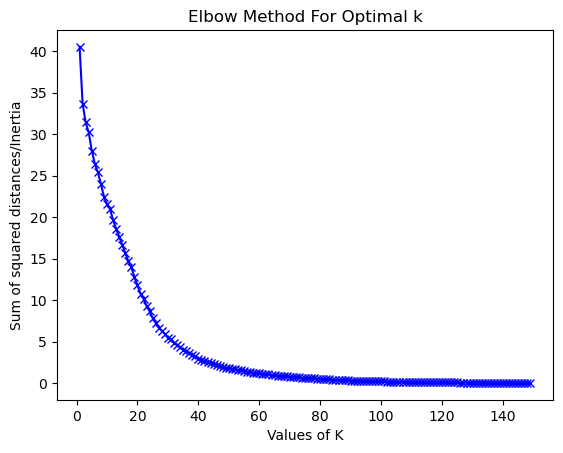

In [27]:
Sum_of_squared_distances = []
K = range(1,150)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_beer_style_score_good)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like the elbow is around the value of K=35

In [281]:
#running k-means with the found optimal k
kmeans = KMeans(35)
kmeans.fit(df_beer_style_score_good)
clusters=kmeans.fit_predict(df_beer_style_score_good)

In [282]:
clusters_data=df_beer_style_score_good.copy()
#assigning the clusters to the data 
clusters_data['Cluster']=clusters

Next we want to plot the clusters on a map, so we use data with the longitutde and latitudes of each country and each state in the United States: 

In [283]:
plotting_data = clusters_data.join(df_coordinates)
plotting_data = plotting_data.dropna(axis=0)

In [284]:
#So we have the assigned Cluster, Longitude and Latitude to each data point:
plotting_data[['Cluster', 'Longitude', 'Latitude']].head()

,Cluster,Longitude,Latitude
"United States, Georgia",1,-82.907123,32.157435
"United States, New Jersey",1,-74.405661,40.058324
"United States, Alaska",1,-154.493062,63.588753
Northern Ireland,1,6.492300,54.7877
"United States, North Carolina",1,-79.019300,35.759573


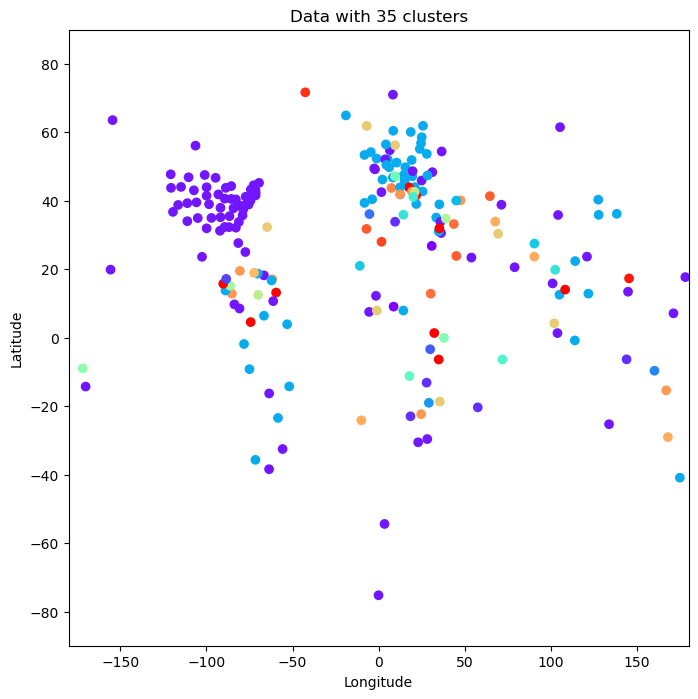

In [285]:
#Visualizing the clusters on the longitude and latitude
plt.figure(figsize=(8,8))
plt.scatter(plotting_data['Longitude'], plotting_data['Latitude'], c=plotting_data['Cluster'],cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Data with 35 clusters") 
plt.xlim(-180,180)
plt.ylim(-90, 90)
plt.show()

Finally, let's visualize the map with  Plotly:

In [292]:
fig = go.Figure(data=go.Scattergeo(
        lon = plotting_data['Longitude'],
        lat = plotting_data['Latitude'],
        text = plotting_data.index,
        hovertext=plotting_data.index,
        hoverinfo='text',
        mode = 'markers',
        marker_color = plotting_data['Cluster'],
        hovertemplate='%{text}<br>Cluster: %{marker.color}<extra></extra>'
        ))

# Customize the layout and show the plot
fig.update_layout(
    geo=go.layout.Geo(
        showframe=True,
        showcoastlines=True,
        projection_type='natural earth2',
        showcountries= True
    ),
    hovermode='closest',
    paper_bgcolor = 'rgba(0,0,0,0)',
    width=1200,
    height=900,
    title='World Map with style clusters'
)
fig.show()

fig.write_html('../plots_html/map1.html')


### Assigning different weights according to the rating

Next we try out a different way to create the vectors of 'style'. Below, we use all ratings but we assign different weights to the count of reviews depending on the rating: <br>
- Reviews that have a rating lower than 2 get a weight of 1
- Reviews that have a rating higher than 2 and lower than 3 get a weight of 2
- Reviews that have a rating higher than 3 and lower than 4 get a weight of 3
- Reviews that have a rating higher than 4 get a weight of 4

In [84]:
#define dataframes for each category of rating
value_counts_1 = df_reviews_locations.loc[df_reviews_locations['rating']<2]
value_counts_2 = df_reviews_locations.loc[(df_reviews_locations['rating']<3) & (df_reviews_locations['rating']>2)]
value_counts_3 = df_reviews_locations.loc[(df_reviews_locations['rating']<4) & (df_reviews_locations['rating']>3)]
value_counts_4 = df_reviews_locations.loc[df_reviews_locations['rating']>4]

In [85]:
beer_style_score = pd.DataFrame(index=df_reviews_locations['style'].unique()) 

In [73]:
#create a list of the countries contained in the dataframe
countries = df_reviews_locations['user_location'].unique() 
#define a DataFrame where the indices are all the beer styles
beer_style_score = pd.DataFrame(index=df_reviews_locations['style'].unique()) 

#below we create the beer_style_score dataframe which contains 
for country in countries:
    count_1 = value_counts_1.loc[value_counts_1['user_location']==country]['style'].value_counts().reindex(df_reviews_locations['style'].unique(), fill_value=0) #puts 0's for the values where the count was 0
    count_2 = value_counts_2.loc[value_counts_2['user_location']==country]['style'].value_counts().reindex(df_reviews_locations['style'].unique(), fill_value=0)
    count_3 = value_counts_3.loc[value_counts_3['user_location']==country]['style'].value_counts().reindex(df_reviews_locations['style'].unique(), fill_value=0)
    count_4 = value_counts_4.loc[value_counts_4['user_location']==country]['style'].value_counts().reindex(df_reviews_locations['style'].unique(), fill_value=0)
    df_country_weighted_count = pd.DataFrame(normalize([count_1*1 + count_2*2 + count_3*3 + count_4*4])).T
    df_country_weighted_count = df_country_weighted_count.set_index(count_1.index) 
    df_country_weighted_count = df_country_weighted_count.rename(columns={ 0: country})
    beer_style_score = beer_style_score.join(df_country_weighted_count)

df_beer_style_score = beer_style_score.T

We save it into a dataframe because we will use it in the following sections:

In [86]:
df_beer_style_score.to_csv(PATH+'/DataframeStorage/style_scores.csv')

In [372]:
#loading that dataframe
df_beer_style_score = pd.read_csv(PATH+'/DataframeStorage/style_scores.csv' , index_col='Unnamed: 0')

In [88]:
df_beer_style_score

,Euro Pale Lager,English Pale Ale,English Bitter,American Pale Wheat Ale,Irish Red Ale,American Stout,Milk / Sweet Stout,Irish Dry Stout,Munich Helles Lager,English Brown Ale,...,Saké - Ginjo,Saké - Infused,Saké - Tokubetsu,Saké - Junmai,Saké - Nigori,Saké - Koshu,Saké - Taru,Saké - Honjozo,Saké - Genshu,Saké - Futsu-shu
"United States, Washington",0.012461,0.042757,0.007066,0.032431,0.009360,0.044291,0.033522,0.012711,0.010076,0.022889,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000034,0.0,0.0,0.0
"United States, New York",0.027526,0.070530,0.017409,0.062462,0.020781,0.063137,0.059082,0.030932,0.019011,0.040703,...,0.000051,0.0,0.0,0.000135,0.000025,0.000000,0.000051,0.0,0.0,0.0
Northern Ireland,0.051984,0.218411,0.122589,0.019397,0.033751,0.010086,0.030647,0.028708,0.022501,0.027156,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
"United States, North Carolina",0.016175,0.063209,0.011494,0.053570,0.018429,0.077269,0.052634,0.025953,0.018030,0.043030,...,0.000052,0.0,0.0,0.000052,0.000000,0.000052,0.000000,0.0,0.0,0.0
"United States, Illinois",0.022433,0.045016,0.011705,0.063094,0.026713,0.067408,0.059924,0.022391,0.017503,0.029658,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000025,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Saint Lucia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
Micronesia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
Virgin Islands (British),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
Yemen,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [294]:
# Initialize
model = pca()
# Fit transform
out = model.fit_transform(df_beer_style_score)

# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'])

#     PC      feature
# 0  PC1      f1
# 1  PC2      f2
# 2  PC3      f3
# 3  PC4      f4
# 4  PC5      f5
# 5  PC6      f6
# 6  PC7      f7
# 7  PC8      f8
# 8  PC9      f9

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [183] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [55] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [183] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[55]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
       PC               feature   loading  type
0     PC1            Pale Lager  0.462539  best
1     PC2          American IPA  0.385069  best
2     PC3            Pale Lager  0.792607  best
3     PC4  India Pale Ale (IPA)  0.592434  best
4     PC5        Imperial Stout  0.507495  best
..    ...                   ...       ...   ...
192  PC49          Saké - Koshu -0.000032  weak
193  PC50    

In [295]:
#we select unique features because one feature might be associated to several PC's 
top_features = out['topfeat'].head(55).feature.unique()

In [296]:
df_beer_style_score = df_beer_style_score[top_features]

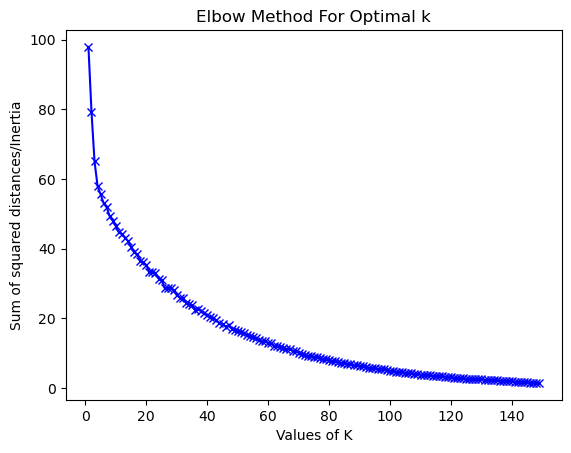

In [137]:
Sum_of_squared_distances = []

K = range(1,150)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_beer_style_score)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [297]:
kmeans = KMeans(25)
kmeans.fit(df_beer_style_score)
clusters=kmeans.fit_predict(df_beer_style_score)

In [298]:
clusters_data = df_beer_style_score.copy()
clusters_data['Cluster']=clusters
plotting_data = clusters_data.join(df_coordinates)
plotting_data = plotting_data.dropna(axis=0)

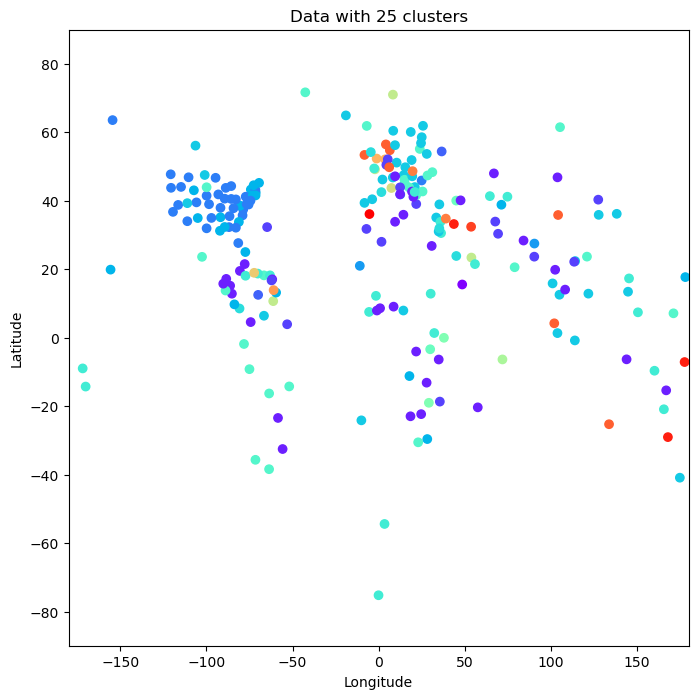

In [299]:
plt.figure(figsize=(8,8))
plt.scatter(plotting_data['Longitude'],plotting_data["Latitude"],c=plotting_data['Cluster'],cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Data with 25 clusters") 
plt.xlim(-180,180)
plt.ylim(-90, 90)
plt.show()

In [300]:
fig = go.Figure(data=go.Scattergeo(
        lon = plotting_data['Longitude'],
        lat = plotting_data['Latitude'],
        text = plotting_data.index,
        hovertext=plotting_data.index,
        hoverinfo='text',
        mode = 'markers',
        marker_color = plotting_data['Cluster'],
        hovertemplate='%{text}<br>Cluster: %{marker.color}<extra></extra>',
        ))

# Customize the layout and show the plot
fig.update_layout(
    geo=go.layout.Geo(
        showframe=True,
        showcoastlines=True,
        projection_type='natural earth2',
        showcountries= True
    ),
    hovermode='closest',
    width=1200,
    height=900,
    title='World Map with style preference clusters',
    paper_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()

fig.write_html('../plots_html/map2.html')

We definitely see major region clusters on this map, the largest 10 clusters are represented below:

In [304]:
print('The largest clusters of countries are:')
clusters_data['Cluster'].value_counts().head(10)

The largest clusters of countries are:


7     39
1     35
4     34
10    25
9     23
6     21
2     15
8      8
21     7
15     5
Name: Cluster, dtype: int64

We consider some of the clusters and want to identify which styles they like and how they do so:

- Cluster 7 contains 39 countries and corresponds to mostly European countries (including Germany, Denmark, France, Switzerland etc.) and other countries around the world that do not cluster in a specific way
- Cluster 4 contains most states from the United States
- Cluster 10 contains a lot of south american countries
- Cluster 6 contains states from the east coast of the United States

The other large clusters had countries spread out in the world without any particular geographical/regional clustering so we omit them for the following analysis:

In [363]:
cluster_vectors = clusters_data.groupby('Cluster').mean()
indices_clusters = [ 7,  4,  10, 6]
radar_plot_data = cluster_vectors.iloc[indices_clusters]

In [364]:
radar_plot_data

,Pale Lager,American IPA,India Pale Ale (IPA),Imperial Stout,Golden Ale/Blond Ale,Euro Pale Lager,Amber Lager/Vienna,Pilsener,Malt Liquor,Porter,...,Irish Ale,Dry Stout,English Pale Ale,Baltic Porter,Amber Ale,Fruit Beer,Spice/Herb/Vegetable,Barley Wine,English Porter,Zwickel/Keller/Landbier
Cluster,,,,,,,,,,,,,,,,,,,,,
7,0.201611,0.030376,0.528032,0.280231,0.104356,0.011498,0.053978,0.129763,0.008771,0.141302,...,0.021488,0.036194,0.040053,0.047332,0.106658,0.080131,0.117711,0.081031,0.003762,0.045654
4,0.104459,0.353194,0.388949,0.278268,0.052707,0.017886,0.045462,0.059668,0.009883,0.141269,...,0.020341,0.034156,0.054005,0.052022,0.093887,0.087616,0.107632,0.118438,0.022835,0.011157
10,0.456976,0.058188,0.351435,0.124042,0.114093,0.035207,0.089504,0.171805,0.015921,0.145096,...,0.026891,0.053364,0.045953,0.072113,0.095902,0.092194,0.107616,0.055693,0.008880,0.045651
6,0.088118,0.508266,0.131937,0.081293,0.039932,0.031557,0.021877,0.021136,0.004509,0.055664,...,0.016572,0.016663,0.058600,0.037942,0.039134,0.034810,0.035982,0.033700,0.037927,0.003000


We want to plot a radar plot with the most interesting categories of beer according to the clusters, since there are 41 styles of beers we extract the ones with the highest absolute value for loadings on PC1 :

In [365]:
most_present_styles = abs(out['loadings'].loc['PC1']).sort_values(ascending= False).head(30).index

In [366]:
radar_plot_df =  radar_plot_data.loc[:, radar_plot_data.columns.isin(most_present_styles)]

We want the radar plot to have the categories spread out and not in a particular order so we generate a df_radar_shuffled which contains the same data as above but with the columns shuffled:

In [370]:
# Generate a random permutation of the column indices
perm = np.random.permutation(radar_plot_df.shape[1])

# Shuffle the column order of the dataframe
df_radar_shuffled = radar_plot_df.iloc[:, perm]
df_radar_shuffled.reset_index(inplace=True)
df_radar_shuffled = df_radar_shuffled.rename(columns = {'index':'Cluster'})

df_radar_shuffled

,Cluster,Brown Ale,Fruit Beer,Russian Imperial Stout,Stout,India Pale Ale (IPA),Porter,Barley Wine,Spice/Herb/Vegetable,Amber Ale,Pale Lager,American Pale Ale,American Pale Ale (APA),Imperial Stout,American IPA
0,7,0.080793,0.080131,0.009986,0.127482,0.528032,0.141302,0.081031,0.117711,0.106658,0.201611,0.262254,0.015575,0.280231,0.030376
1,4,0.097665,0.087616,0.128991,0.094083,0.388949,0.141269,0.118438,0.107632,0.093887,0.104459,0.175508,0.147162,0.278268,0.353194
2,10,0.076210,0.092194,0.022872,0.138369,0.351435,0.145096,0.055693,0.107616,0.095902,0.456976,0.183695,0.025337,0.124042,0.058188
3,6,0.040146,0.034810,0.166716,0.035758,0.131937,0.055664,0.033700,0.035982,0.039134,0.088118,0.061972,0.185223,0.081293,0.508266


In [371]:
#radar plot
# number of variable
categories=(list(df_radar_shuffled)[1:])
categories
#random.shuffle(categories)

data1 = df_radar_shuffled.loc[0].drop('Cluster').values.flatten().tolist()
data2 = df_radar_shuffled.loc[1].drop('Cluster').values.flatten().tolist()
data3 = df_radar_shuffled.loc[2].drop('Cluster').values.flatten().tolist()
data4 = df_radar_shuffled.loc[3].drop('Cluster').values.flatten().tolist()


# Create the figure and plot
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=data1, theta=categories, fill='toself', name='Cluster 7'))
fig.add_trace(go.Scatterpolar(r=data2, theta=categories, fill='toself', name='Cluster 4'))
fig.add_trace(go.Scatterpolar(r=data3, theta=categories, fill='toself', name='Cluster 10'))
fig.add_trace(go.Scatterpolar(r=data4, theta=categories, fill='toself', name='Cluster 6'))

# Customize the layout and show the plot
fig.update_layout(
    polar=go.layout.Polar(
        radialaxis=go.layout.polar.RadialAxis(
            visible=True,
            range=[0, 0.6]
        )
    ),
    showlegend=True,
    width=800,
    height=600,
    title='Radar Plot for the different styles of beer per cluster',
    paper_bgcolor = 'rgba(0,0,0,0)'
)

fig.write_html('../plots_html/radar_plot.html')
fig.show()